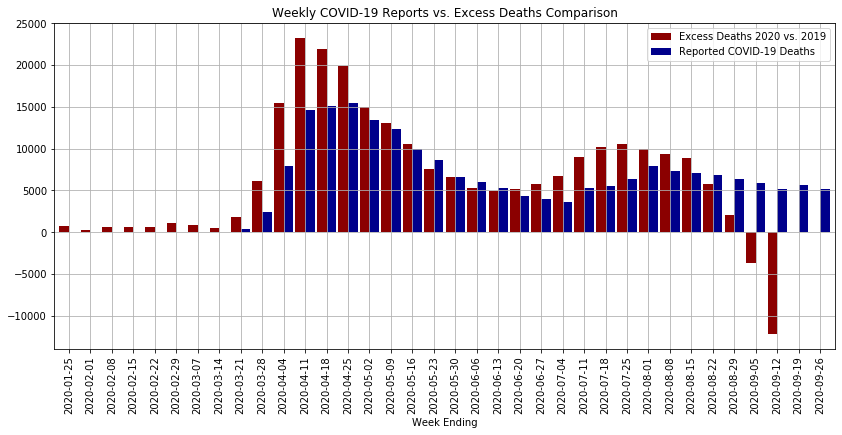

Total Excess Deaths (compared to 2019) between 2020-01-25 and 2020-09-26 :	228,693
Total Reported COVID-19 Deaths between 2020-01-25 and 2020-09-26:		204,490


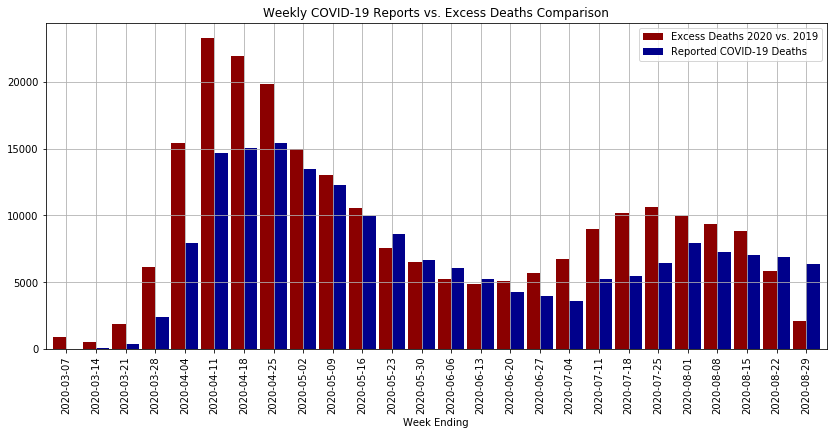

Total Excess Deaths (compared to 2019) between 2020-03-07 and 2020-08-29 :	235,997
Total Reported COVID-19 Deaths between 2020-03-07 and 2020-08-29:		182,713


In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import covid_19_shared

def obtain_reported_deaths():
    reported_data = covid_19_shared.loadJHUData("US", True)
    reported_covid_deaths = (reported_data.Dead - reported_data.Dead.shift(1)).dropna().resample('1W-SAT').sum()
    reported_covid_deaths.index = reported_covid_deaths.index.strftime('%Y-%m-%d')
    return reported_covid_deaths

def get_year(df : pd.DataFrame, year : int):
    is_yr = df.Year == year
    return df[is_yr]

def obtain_excess_deaths():
    '''
    CDC Data Source: https://data.cdc.gov/resource/muzy-jte6
    '''
    # Read from URL
    url="https://data.cdc.gov/api/views/muzy-jte6/rows.csv"
    df = pd.read_csv(url)

    # Filter USA only

    is_us=df["Jurisdiction of Occurrence"] == "United States"
    df2 = df[is_us]

    # Drop Unused Columns:
    columns_to_delete = [0]
    for col in range(5, len(df2.columns)):
        columns_to_delete.append(col)
    df2 = df2.drop(df2.columns[columns_to_delete], axis=1) 


    # Rename columns
    df2 = df2.rename({"MMWR Year": 'Year'
               , "MMWR Week": 'Week'
               , "All Cause": 'NumDeaths'
               , "Week Ending Date" : "WkDt"
            }, axis='columns')
    # df2


    years = [2019, 2020]
    data_by_year = dict()
    for year in years:
        data_by_year[year] = get_year(df2, year)
        data_by_year[year].set_index('Week', inplace=True)


    df_2019 = data_by_year[2019]
    df_2020 = data_by_year[2020]
    diff = (df_2020.NumDeaths - df_2019.NumDeaths).dropna().array

    df = df_2020.set_index('WkDt')
    df.loc[:, 'Diff'] = diff
    excess_deaths_df = df.drop(df.columns[[0, 1]], axis=1)
    return excess_deaths_df.Diff

def report_diff(reported_death : pd.Series, excess_deaths : pd.Series):
    
    df = pd.DataFrame({
                        "Excess Deaths 2020 vs. 2019":  excess_deaths
                        , "Reported COVID-19 Deaths" :  reported_death
                      }
                      , index=reported_death.index)
    excess_sum = int(excess_deaths.sum())
    reported_sum = int(reported_death.sum())

    from_date = reported_death.index[0]
    to_date = reported_death.index[-1]

    txt1 = f"Total Excess Deaths (compared to 2019) between {from_date} and {to_date} :\t{excess_sum:,}"
    txt2 = f"Total Reported COVID-19 Deaths between {from_date} and {to_date}:\t\t{reported_sum:,}"

    df.index.names = ["Week Ending"]
    df.plot(kind='bar'
            , stacked=False
            , figsize=(14, 6)
            , legend=True
            , grid = True
            , width = 0.9
            , color = ['darkred', 'darkblue']
            , title = "Weekly COVID-19 Reports vs. Excess Deaths Comparison"
            )
    plt.show()
    print(txt1)
    print(txt2)

#-------------------- Report


reported_covid_deaths = obtain_reported_deaths()
excess_deaths = obtain_excess_deaths()
report_diff(reported_covid_deaths, excess_deaths)

# Eliminate/lag early unrelated data and latest incompleted data
report_diff(reported_covid_deaths["2020-03-07":'2020-08-29']
            ,  excess_deaths["2020-03-07":'2020-08-29'])

